# CameraView, Offscreen (headless), and Realistic Rendering

The `view` is realized using very basic OpenGL rendering. It is straight-forward to grab the image (and, e.g., make a video from such images), as well as the depth (e.g. to simulate a depth camera).

However, grabbing from the actual view window is brittle, as it depends on the window manager and might give weird results if the window is not visible. The package provides an offscreen (headless) implementation of the OpenGL rendering, which allows to compute images and depth (also object segmentation labels) without window or X.

The simple OpenGL rendering is ok for depth camera simulation, but not visually realistic. An interface to Nvidia's NVISSI physics-based rendering enables very flexible realistic rendering.

## Grabbing images and depth from the view window
The view is internally implemented using glfw and most basic opengl. It's simple to grab the rgb and depth buffers.

In [1]:
from robotic import ry
import numpy as np
import matplotlib.pyplot as plt
print(ry.__version__, ry.compiled())

0.0.23 compile time: Oct 19 2023 13:43:51


In [2]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [3]:
rgb = C.view_getRgb()
depth = C.view_getDepth()
print(rgb.shape, depth.shape)

(400, 400, 3) (400, 400)


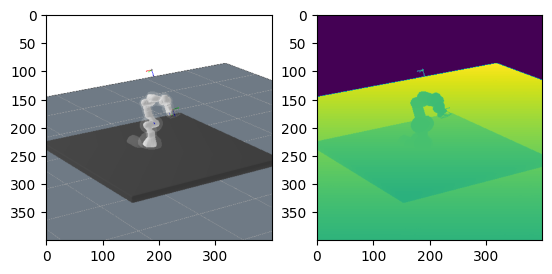

In [4]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(rgb)
fig.add_subplot(1,2,2)
plt.imshow(depth)
plt.show()

The camera pose can be set to be at a particular frame. (Create a dedicated frame, if you want freedom to set the camera). Also camera intrinsics (focalLength, width, height) can be set with frame attributes. Our scene has a `cameraTop` predefined:

In [5]:
f = C.getFrame('cameraTop')
f.setAttribute('focalLength', .5) # wide angle
f.setAttribute('width', 200) # super wide angle
f.setAttribute('height', 200) # super wide angle
C.view_setCamera(f)

## Saving pngs for video generation

There might be many better ways to generate a video. But a simple one it to write many numered pngs and call ffmpeg on shell. For instance:

In [6]:
# first ensure a folder
import os
os.system('mkdir -p z.vid') 

0

In [7]:
q = C.getJointState()

for t in range(30):
    q = q + .02
    C.setJointState(q)
    C.view()
    C.view_savePng('z.vid/')

In [8]:
os.system('ffmpeg -v 16 -f image2 -framerate 12 -i z.vid/%04d.png -c:v libx264 -r 25 -pix_fmt yuv420p -y vid.mp4')

0

...which creates an mp4 with 12 images per second.

## Offscreen (headless) CameraView

But this way of grabbing images and depth from the view window is brittle (as it depends on the window manager) and also includes markers and non-visual objects. A much better way is to use offscreen method:

In [9]:
cam = ry.CameraView(C)

In [10]:
rgb, depth = cam.computeImageAndDepth(C)

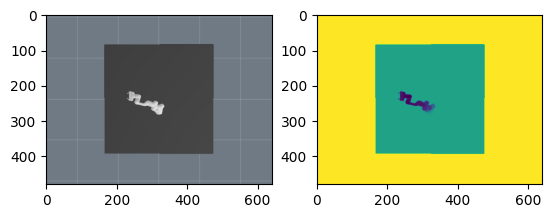

In [11]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(rgb)
fig.add_subplot(1,2,2)
plt.imshow(depth)
plt.show()

In [12]:
cam.setCamera('cameraTop') # cameraWrist is another pre-defined frame

In [13]:
rgb, depth = cam.computeImageAndDepth(C)

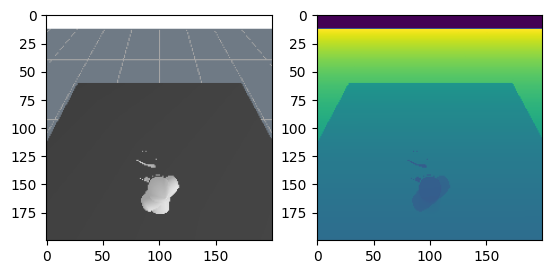

In [14]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(rgb)
fig.add_subplot(1,2,2)
plt.imshow(depth)
plt.show()

## Point Cloud

In [15]:
from robotic import ry
import matplotlib.pyplot as plt

In [16]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [17]:
cam = ry.CameraView(C)
cam.setCamera('cameraTop')
rgb, depth = cam.computeImageAndDepth(C)
pcl = ry.depthImage2PointCloud(depth, cam.getFxyCxy())

In [18]:
print(rgb.shape, depth.shape, pcl.shape)
print(C.view_fxycxy())

(360, 640, 3) (360, 640) (360, 640, 3)
[1881.85195923 1881.85195923  200.          200.        ]


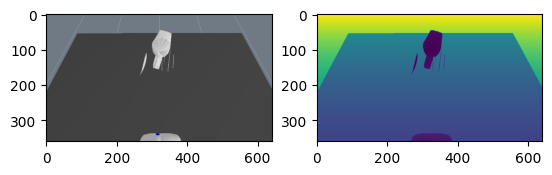

In [19]:
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(rgb)
fig.add_subplot(1,2,2)
plt.imshow(depth)
plt.show()

In [20]:
C.delFrame('pcl2')
f = C.addFrame('pcl2', 'cameraTop')
f.setPointCloud(pcl, [255,0,0])
C.view()

-- WARNING:kin.cpp:getFrame:392(-1) cannot find frame named 'pcl2'


0

## Physics-based Rendering using Nvidia NVISII

In [1]:
from robotic import ry
from matplotlib import pyplot as plt
from robotic import render
print('version', ry.compiled())

version compile time: Oct 19 2023 13:43:51


In [2]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [3]:
C.addFrame('light1') .setPosition([1,0,2]) .setShape(ry.ST.ssBox, [.5,2,.1,.02]) .setColor([.5]) .setAttribute('temperature', 6000)
C.addFrame('light2') .setPosition([-1,0,2]) .setShape(ry.ST.ssBox, [.5,2,.1,.02]) .setColor([.8]) .setAttribute('temperature', 6000)
C.view()

37

In [4]:
nv = render.NvisiiRenderer(600, 400, C.view_focalLength())
nv.addConfig(C)

Found 7 GPUs available for rendering.
=== creating table
=== creating l_panda_link0_0
=== creating l_panda_link1_0
=== creating l_panda_link2_0
=== creating l_panda_link3_0
=== creating l_panda_link4_0
=== creating l_panda_link5_0
=== creating l_panda_link6_0
=== creating l_panda_link7_0
=== creating l_panda_hand_0
=== creating l_panda_leftfinger_0
=== creating l_panda_rightfinger_0
=== creating light1
=== creating light light1
=== creating light2
=== creating light light2


rendering...
 256/256 - done!


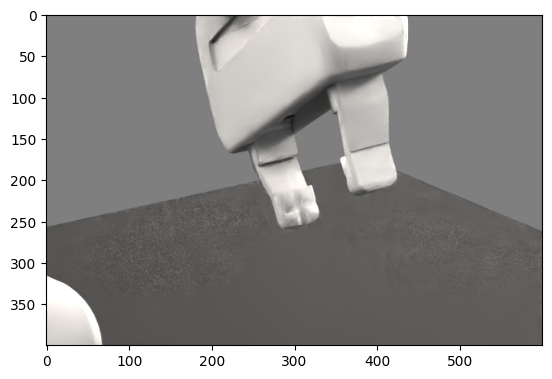

In [9]:
nv.setCamera(C)
rgb = nv.render(256)
plt.imshow(rgb)
plt.show()

In [7]:
del nv

-- shutting down Nvisii
